# gene2csm.py

## Example usage

Use magic for inline interactive plotting.

In [1]:
%matplotlib inline

Do the imports.

In [2]:
import gffutils
import os
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd

# import gene2csm modules
from gene2csm import *
from gene2csm_out import prepare_output

---

### Create the required database objects

Create or load the GFF annotation database

In [3]:
db_file = 'danRer.GRCz10.90.db'
if not os.path.exists(db_file):
    db = gffutils.create_db("Danio_rerio.GRCz10.90.gtf",
                            dbfn="danRer.GRCz10.90.db",
                            id_spec={'gene': 'gene_id', 'transcript': "transcript_id"},
                            disable_infer_genes=True,
                            disable_infer_transcripts=True,
                            force=False)
else:
    db = gffutils.FeatureDB(db_file)

Create an indexed fasta database for faster access with SeqIO.

In [4]:
fa_db = SeqIO.index_db('danRer.GRCz10.dna_sm.toplevel.idx', 'Danio_rerio.GRCz10.dna_sm.toplevel.fa', 'fasta')

Load the variation information.

In [5]:
gvf_fn = ('danio_rerio.gvf.gz')

---

### Basic example of working with provided functions

Enter the Ensembl Gene ID

In [6]:
gene = db['ENSDARG00000008454']

Create genomic sequence coverage by **CDS** (without STOP codon).

In [7]:
gene_cov = get_cov(db, gene)

ENSDARG00000008454 loci length: 10529.
Maximal genomic sequence coverage by CDS: 3.


For ploting change start coordinates to local and reverse the coverage if needed

In [8]:
if gene.strand == '+':
    plot_cov = gene_cov
else:
    plot_cov = gene_cov[::-1]

Plotting

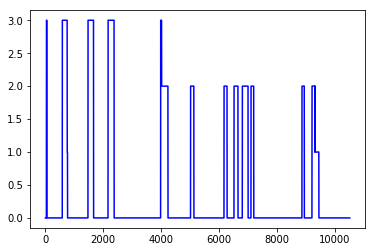

In [9]:
plt.plot(plot_cov, 'blue')
plt.show()

Get the genomic intervals for sequene retrieval. Subtract the varable sequences comming from dbSNP.

In [10]:
gen_int = sub_var(get_int(gene,gene_cov), gvf_fn)

17 CDS coverage intervals (coverage, count): [(2, 9), (3, 5), (1, 3)].
Subtracting variation from dbSNP_150.


---

### Automated design for multiple transcript targets

Define search parameters.

In [ ]:
# length of the designed oligo
crRNA_len = 36
# limits of the %GC content
GC_limit = (40,60)
# number of processors to use
n_threads = 7

Provide the list of Ensembl Gene IDs to be used as design targets.

In [ ]:
targets = ['ENSDARG00000008454', 
           'ENSDARG00000012389',
           'ENSDARG00000101576',
           'ENSDARG00000014373',
           'ENSDARG00000035095',
           'ENSDARG00000017821']

Use the main function to conduct all the calculations. Raw output will also be stored in the CSV file. 

In [ ]:
out = gene2csm(db, fa_db, gvf_fn, targets, crRNA_len, GC_limit, n_threads, coverage_limit='max')

Score the output, format the tables and write them to the XLSX files (if `write=True`).

In [ ]:
formated = prepare_output(out, n_store=0, write=False)

Analyze the output for each target. For convenience the result dictionary contains the Gene Names as keys.

In [ ]:
formated['ta'].head()

---

### Working with user provided input

#### Sequence not part of an endogenous transcript

Input sequence should be provided in PLAIN or FASTA format. 

You can use lowercase letters to mask unwanted sequence regions.

In [ ]:
egfp_seq = 'aggatccaccggtcgccaccatggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagtaaagcggccgc'

Use the `estimate_energy_input()` function for crRNA design, specifying the lenght of the designed oligos and the %GC content limits.

The user provided sequence will be used for free energy calculations.

Every designed oligo will be subject to a BLAST database search agains all of the species RNA sequences.

In the example below we convert the whole sequence to uppercase as the argument for the function call:

In [ ]:
egfp_res = estimate_energy_input(egfp_seq.upper(), 36, (0,100), proc=7)

Score and format the output. As input for `prepare_output()` function provide a list of tuples, containing sequence id and result from previous function call.

In [ ]:
egfp_out = prepare_output([('eGFP', egfp_res)], n_store=0, write=False)

Analyze the output.

In [ ]:
egfp_out['eGFP'].head()

#### Sequence fragment of endogenous transcript

Input sequence should be provided in the FASTA format, containing parent **Ensembl Transcript ID** as the first element of the header (right after the '>' sign).

In [ ]:
cpeb1b_2nd_exon_part = '>ENSDART00000098904 exon 2; partial sequence\nGCAGACGCCTTCTGCAGAATGAACACCATGCTGGGCAACTCACTGGATCTGAGTGGTGTGTGCACAACTCCCACTGCCAAGTGCAAGCGAGACCCTTTTA'

As in the example above use the `estimate_energy_input()` function to perform the calculations. This time provide also the **annotation database** and **fasta index** for the database lookup of the parent transcript sequence.

The whole parent transcript sequence will be used for free energy calculations.

The BLAST database search will exclude all of the transcript sequences of the parent gene.

In [ ]:
cpeb1b_part_res = estimate_energy_input(cpeb1b_2nd_exon_part, 36, (40,60), database=db, fasta_index=fa_db, proc=7)

Score and format the output.

In [ ]:
cpeb1b_part_out = prepare_output([('cpeb1b', cpeb1b_part_res)], n_store=0, write=False)

Analyze the output.

In [ ]:
cpeb1b_part_out['cpeb1b'].head()

---

### Omiting certain *CDS containing exons* from processing

In [11]:
gen_int

[['7', 47969001, 47969059, 1],
 ['7', 47969061, 47969131, 1],
 ['7', 47969131, 47969136, 2],
 ['7', 47969136, 47969137, 1],
 ['7', 47969137, 47969239, 2],
 ['7', 47969505, 47969586, 2],
 ['7', 47971254, 47971349, 2],
 ['7', 47971450, 47971529, 2],
 ['7', 47971530, 47971538, 2],
 ['7', 47971539, 47971649, 2],
 ['7', 47971799, 47971934, 2],
 ['7', 47971935, 47971936, 2],
 ['7', 47972177, 47972282, 2],
 ['7', 47973325, 47973359, 2],
 ['7', 47973360, 47973439, 2],
 ['7', 47974221, 47974441, 2],
 ['7', 47974441, 47974474, 3],
 ['7', 47976084, 47976150, 3],
 ['7', 47976151, 47976293, 3],
 ['7', 47976795, 47976925, 3],
 ['7', 47976926, 47976987, 3],
 ['7', 47977695, 47977707, 1],
 ['7', 47977707, 47977814, 3],
 ['7', 47977815, 47977834, 3],
 ['7', 47977835, 47977876, 3],
 ['7', 47978410, 47978425, 3]]

In [12]:
gene.strand

'-'

In [13]:
gen_int = get_int(gene,gene_cov)

17 CDS coverage intervals (coverage, count): [(2, 9), (3, 5), (1, 3)].


In [14]:
gen_int

[['7', 47969001, 47969131, 1],
 ['7', 47969131, 47969136, 2],
 ['7', 47969136, 47969137, 1],
 ['7', 47969137, 47969239, 2],
 ['7', 47969505, 47969586, 2],
 ['7', 47971254, 47971349, 2],
 ['7', 47971450, 47971649, 2],
 ['7', 47971799, 47971936, 2],
 ['7', 47972177, 47972282, 2],
 ['7', 47973325, 47973439, 2],
 ['7', 47974221, 47974441, 2],
 ['7', 47974441, 47974474, 3],
 ['7', 47976084, 47976293, 3],
 ['7', 47976795, 47976987, 3],
 ['7', 47977695, 47977707, 1],
 ['7', 47977707, 47977876, 3],
 ['7', 47978410, 47978425, 3]]

In [15]:
gen_int2 = sub_user(get_int(gene,gene_cov), gene.strand, None)

17 CDS coverage intervals (coverage, count): [(2, 9), (3, 5), (1, 3)].


In [16]:
gen_int2

[['7', 47969001, 47969131, 1],
 ['7', 47969131, 47969136, 2],
 ['7', 47969136, 47969137, 1],
 ['7', 47969137, 47969239, 2],
 ['7', 47969505, 47969586, 2],
 ['7', 47971254, 47971349, 2],
 ['7', 47971450, 47971649, 2],
 ['7', 47971799, 47971936, 2],
 ['7', 47972177, 47972282, 2],
 ['7', 47973325, 47973439, 2],
 ['7', 47974221, 47974441, 2],
 ['7', 47974441, 47974474, 3],
 ['7', 47976084, 47976293, 3],
 ['7', 47976795, 47976987, 3],
 ['7', 47977695, 47977707, 1],
 ['7', 47977707, 47977876, 3],
 ['7', 47978410, 47978425, 3]]

In [17]:
gen_int == gen_int2

True

In [ ]:
gen_int2 = sub_user(get_int(gene,gene_cov), gene.strand, [,3])